# First NN with torch 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [2]:
# Data upload
file_path = "data/voice.csv"
data = pd.read_csv(file_path)
data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values
y = data['label'].values

In [3]:
# Pre-processing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
# Creation of the Neural Network 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, use_batch_norm=True, noise_scale=0.0):
        super(NeuralNetwork, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.noise_scale = noise_scale
        
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        if self.noise_scale > 0:
            x = x + torch.randn_like(x) * self.noise_scale
        x = self.relu(x)

        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        if self.noise_scale > 0:
            x = x + torch.randn_like(x) * self.noise_scale
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Train fonction
def train_model(model, train_loader, test_loader, epochs=30, learning_rate=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)
            predictions = (outputs >= 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
        
        train_loss = epoch_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.legend()
    plt.show()

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions = (outputs >= 0.5).float()
            y_true.extend(y_batch.numpy().flatten())
            y_pred.extend(predictions.numpy().flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
    cm_display.plot(cmap='Blues')
    plt.show()

def compute_gini(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)
    gini_score = 2 * auc_score - 1
    return gini_score, fpr, tpr


=== BatchNorm + Noise 0.5 ===
Epoch 1/30 - Loss: 0.6853, Accuracy: 0.5663
Epoch 2/30 - Loss: 0.6714, Accuracy: 0.5825
Epoch 3/30 - Loss: 0.6017, Accuracy: 0.6894
Epoch 4/30 - Loss: 0.5399, Accuracy: 0.7498
Epoch 5/30 - Loss: 0.4888, Accuracy: 0.7901
Epoch 6/30 - Loss: 0.4302, Accuracy: 0.8220
Epoch 7/30 - Loss: 0.4228, Accuracy: 0.8252
Epoch 8/30 - Loss: 0.3033, Accuracy: 0.8824
Epoch 9/30 - Loss: 0.2818, Accuracy: 0.8883
Epoch 10/30 - Loss: 0.3021, Accuracy: 0.8816
Epoch 11/30 - Loss: 0.3284, Accuracy: 0.8567
Epoch 12/30 - Loss: 0.2604, Accuracy: 0.8871
Epoch 13/30 - Loss: 0.2183, Accuracy: 0.9152
Epoch 14/30 - Loss: 0.2591, Accuracy: 0.8970
Epoch 15/30 - Loss: 0.1796, Accuracy: 0.9305
Epoch 16/30 - Loss: 0.1848, Accuracy: 0.9353
Epoch 17/30 - Loss: 0.1754, Accuracy: 0.9337
Epoch 18/30 - Loss: 0.2332, Accuracy: 0.9077
Epoch 19/30 - Loss: 0.1675, Accuracy: 0.9424
Epoch 20/30 - Loss: 0.1739, Accuracy: 0.9392
Epoch 21/30 - Loss: 0.1657, Accuracy: 0.9459
Epoch 22/30 - Loss: 0.1496, Accur

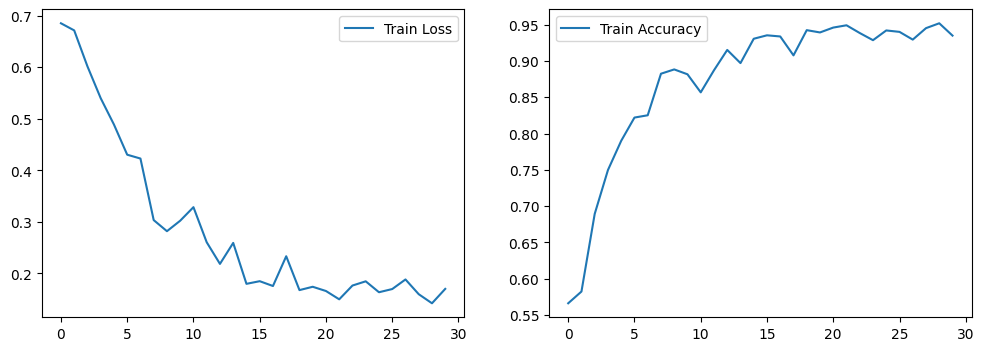

Gini Score (BatchNorm + Noise 0.5): 0.9763

=== BatchNorm + Noise 1 ===
Epoch 1/30 - Loss: 0.6798, Accuracy: 0.5596
Epoch 2/30 - Loss: 0.6475, Accuracy: 0.6247
Epoch 3/30 - Loss: 0.6027, Accuracy: 0.6780
Epoch 4/30 - Loss: 0.5817, Accuracy: 0.7028
Epoch 5/30 - Loss: 0.5448, Accuracy: 0.7356
Epoch 6/30 - Loss: 0.5132, Accuracy: 0.7699
Epoch 7/30 - Loss: 0.4441, Accuracy: 0.7983
Epoch 8/30 - Loss: 0.4520, Accuracy: 0.7940
Epoch 9/30 - Loss: 0.3973, Accuracy: 0.8240
Epoch 10/30 - Loss: 0.4293, Accuracy: 0.8165
Epoch 11/30 - Loss: 0.4444, Accuracy: 0.7960
Epoch 12/30 - Loss: 0.3859, Accuracy: 0.8477
Epoch 13/30 - Loss: 0.3385, Accuracy: 0.8670
Epoch 14/30 - Loss: 0.3256, Accuracy: 0.8670
Epoch 15/30 - Loss: 0.3291, Accuracy: 0.8706
Epoch 16/30 - Loss: 0.3195, Accuracy: 0.8765
Epoch 17/30 - Loss: 0.3815, Accuracy: 0.8358
Epoch 18/30 - Loss: 0.2952, Accuracy: 0.8781
Epoch 19/30 - Loss: 0.2651, Accuracy: 0.8844
Epoch 20/30 - Loss: 0.3142, Accuracy: 0.8737
Epoch 21/30 - Loss: 0.2999, Accuracy:

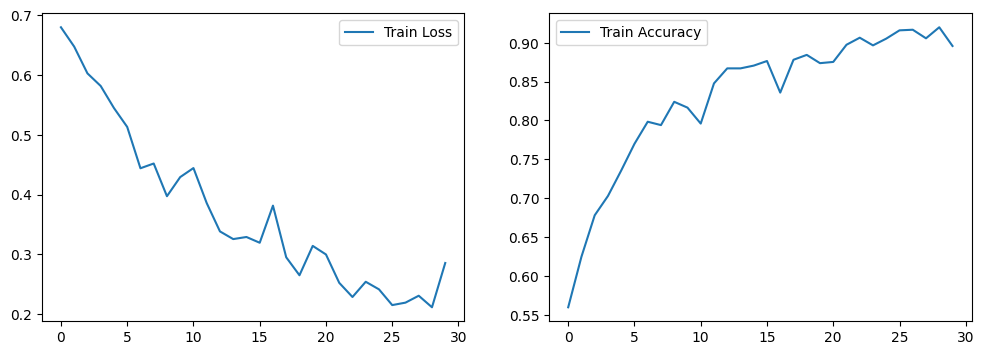

Gini Score (BatchNorm + Noise 1): 0.9308

=== BatchNorm + Noise 2 ===
Epoch 1/30 - Loss: 0.7253, Accuracy: 0.5193
Epoch 2/30 - Loss: 0.6934, Accuracy: 0.5225
Epoch 3/30 - Loss: 0.6850, Accuracy: 0.5458
Epoch 4/30 - Loss: 0.6748, Accuracy: 0.5710
Epoch 5/30 - Loss: 0.6680, Accuracy: 0.5951
Epoch 6/30 - Loss: 0.6154, Accuracy: 0.6630
Epoch 7/30 - Loss: 0.5722, Accuracy: 0.7080
Epoch 8/30 - Loss: 0.5715, Accuracy: 0.6977
Epoch 9/30 - Loss: 0.5494, Accuracy: 0.7297
Epoch 10/30 - Loss: 0.5321, Accuracy: 0.7455
Epoch 11/30 - Loss: 0.4776, Accuracy: 0.7908
Epoch 12/30 - Loss: 0.4449, Accuracy: 0.7960
Epoch 13/30 - Loss: 0.4659, Accuracy: 0.8023
Epoch 14/30 - Loss: 0.3918, Accuracy: 0.8410
Epoch 15/30 - Loss: 0.4252, Accuracy: 0.8283
Epoch 16/30 - Loss: 0.3762, Accuracy: 0.8493
Epoch 17/30 - Loss: 0.3903, Accuracy: 0.8319
Epoch 18/30 - Loss: 0.3751, Accuracy: 0.8449
Epoch 19/30 - Loss: 0.3646, Accuracy: 0.8504
Epoch 20/30 - Loss: 0.4830, Accuracy: 0.7873
Epoch 21/30 - Loss: 0.3528, Accuracy: 0

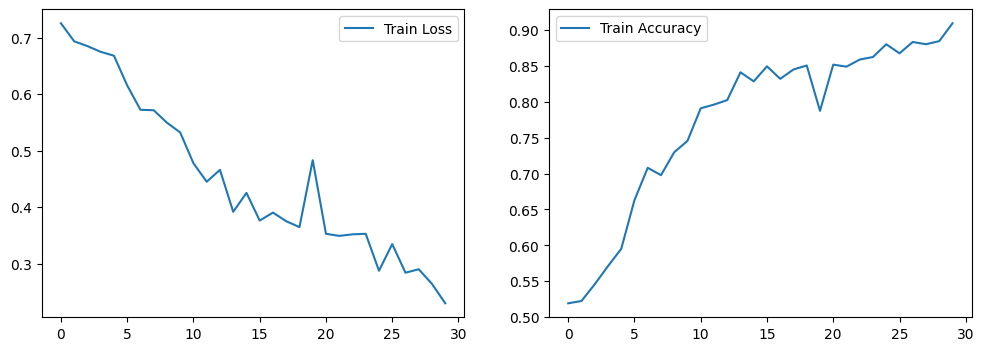

Gini Score (BatchNorm + Noise 2): 0.9642

=== BatchNorm ===
Epoch 1/30 - Loss: 0.6478, Accuracy: 0.6346
Epoch 2/30 - Loss: 0.5397, Accuracy: 0.7577
Epoch 3/30 - Loss: 0.4623, Accuracy: 0.8031
Epoch 4/30 - Loss: 0.3791, Accuracy: 0.8516
Epoch 5/30 - Loss: 0.3248, Accuracy: 0.8745
Epoch 6/30 - Loss: 0.2827, Accuracy: 0.8895
Epoch 7/30 - Loss: 0.2499, Accuracy: 0.9025
Epoch 8/30 - Loss: 0.2342, Accuracy: 0.9061
Epoch 9/30 - Loss: 0.2808, Accuracy: 0.8990
Epoch 10/30 - Loss: 0.2424, Accuracy: 0.9132
Epoch 11/30 - Loss: 0.2099, Accuracy: 0.9242
Epoch 12/30 - Loss: 0.1989, Accuracy: 0.9262
Epoch 13/30 - Loss: 0.1642, Accuracy: 0.9448
Epoch 14/30 - Loss: 0.1694, Accuracy: 0.9408
Epoch 15/30 - Loss: 0.1704, Accuracy: 0.9412
Epoch 16/30 - Loss: 0.1580, Accuracy: 0.9455
Epoch 17/30 - Loss: 0.1574, Accuracy: 0.9495
Epoch 18/30 - Loss: 0.1578, Accuracy: 0.9483
Epoch 19/30 - Loss: 0.1684, Accuracy: 0.9455
Epoch 20/30 - Loss: 0.1510, Accuracy: 0.9574
Epoch 21/30 - Loss: 0.1351, Accuracy: 0.9491
Epoc

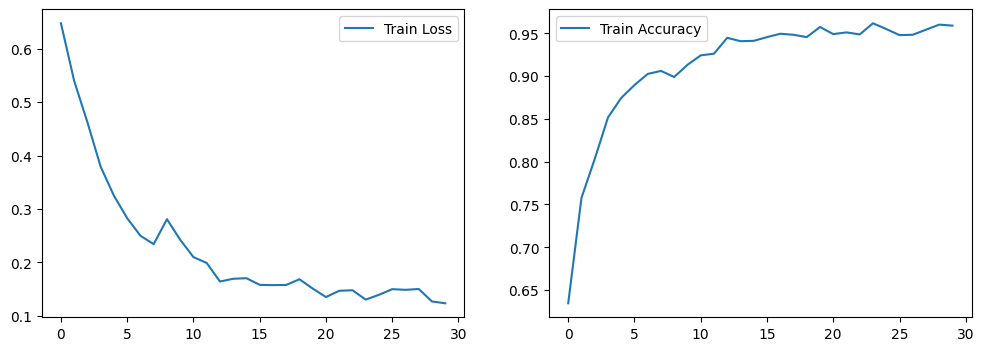

Gini Score (BatchNorm): 0.9875

=== No BatchNorm ===
Epoch 1/30 - Loss: 0.6922, Accuracy: 0.5197
Epoch 2/30 - Loss: 0.6634, Accuracy: 0.5683
Epoch 3/30 - Loss: 0.5922, Accuracy: 0.7115
Epoch 4/30 - Loss: 0.5338, Accuracy: 0.7443
Epoch 5/30 - Loss: 0.4922, Accuracy: 0.7719
Epoch 6/30 - Loss: 0.4790, Accuracy: 0.7893
Epoch 7/30 - Loss: 0.4807, Accuracy: 0.8031
Epoch 8/30 - Loss: 0.4413, Accuracy: 0.7995
Epoch 9/30 - Loss: 0.4005, Accuracy: 0.8272
Epoch 10/30 - Loss: 0.4016, Accuracy: 0.8275
Epoch 11/30 - Loss: 0.3749, Accuracy: 0.8406
Epoch 12/30 - Loss: 0.3580, Accuracy: 0.8564
Epoch 13/30 - Loss: 0.3368, Accuracy: 0.8619
Epoch 14/30 - Loss: 0.3175, Accuracy: 0.8729
Epoch 15/30 - Loss: 0.3099, Accuracy: 0.8781
Epoch 16/30 - Loss: 0.2856, Accuracy: 0.8848
Epoch 17/30 - Loss: 0.2784, Accuracy: 0.8879
Epoch 18/30 - Loss: 0.2570, Accuracy: 0.8966
Epoch 19/30 - Loss: 0.2575, Accuracy: 0.8891
Epoch 20/30 - Loss: 0.2362, Accuracy: 0.8946
Epoch 21/30 - Loss: 0.2104, Accuracy: 0.9057
Epoch 22/30

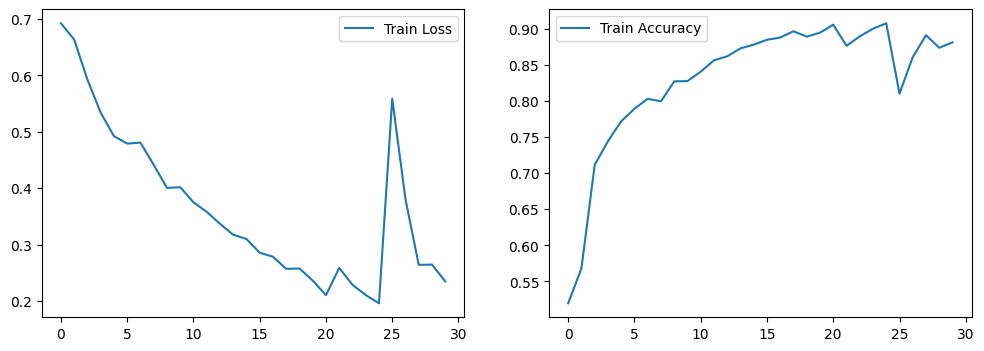

Gini Score (No BatchNorm): 0.9495


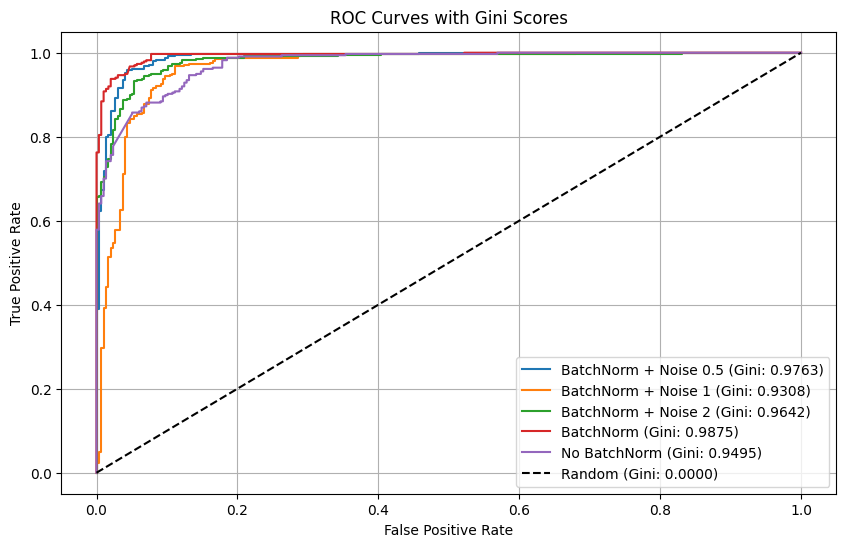

In [5]:
configs = [
    ("BatchNorm + Noise 0.5", True, 0.5),
    ("BatchNorm + Noise 1", True, 1),
    ("BatchNorm + Noise 2", True, 2),
    ("BatchNorm", True, 0.0),
    ("No BatchNorm", False, 0.0),
]

gini_results = []

for config_name, use_bn, noise_scale in configs:
    print(f"\n=== {config_name} ===")
    model = NeuralNetwork(input_size=X_train.shape[1], use_batch_norm=use_bn, noise_scale=noise_scale)
    model = train_model(model, train_loader, test_loader, epochs=30, learning_rate=0.01)
    
    # Evaluation
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_true.extend(y_batch.numpy().flatten())
            y_probs.extend(outputs.numpy().flatten())

    gini_score, fpr, tpr = compute_gini(y_true, y_probs)
    gini_results.append((config_name, gini_score, fpr, tpr))

    print(f"Gini Score ({config_name}): {gini_score:.4f}")

# ROC and Gini score
plt.figure(figsize=(10, 6))
for config_name, gini_score, fpr, tpr in gini_results:
    plt.plot(fpr, tpr, label=f"{config_name} (Gini: {gini_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random (Gini: 0.0000)")
plt.title("ROC Curves with Gini Scores")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()